In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

py.sign_in("parikkap", "vUR2vsPpcmhl5qZQ0NlT")

from sklearn import model_selection
from sklearn import preprocessing, svm, cross_validation
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit


pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader.data import DataReader

/Users/peterparikka/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



 Read in data

In [2]:
end = dt.datetime.now()
start = end - dt.timedelta(days=5*365)

df_tesla = DataReader('TSLA', 'iex', start, end)
df_tesla1 = DataReader('TSLA', 'iex', start, end)
#df_tesla.reset_index(inplace=True)
df_tesla.index = pd.to_datetime(df_tesla.index, format='%Y-%m-%d')
# Drop row if null
df_tesla.dropna(inplace=True)


5y
5y


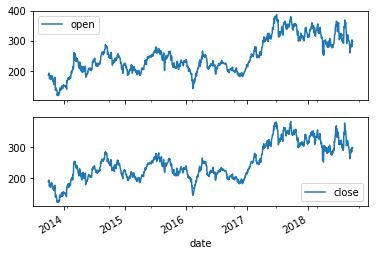

In [3]:

fig = plt.figure()
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

#set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

df_tesla[['open']].plot(ax=ax1)
df_tesla[['close']].plot(ax=ax2)

plt.legend(loc=4)

plt.show()

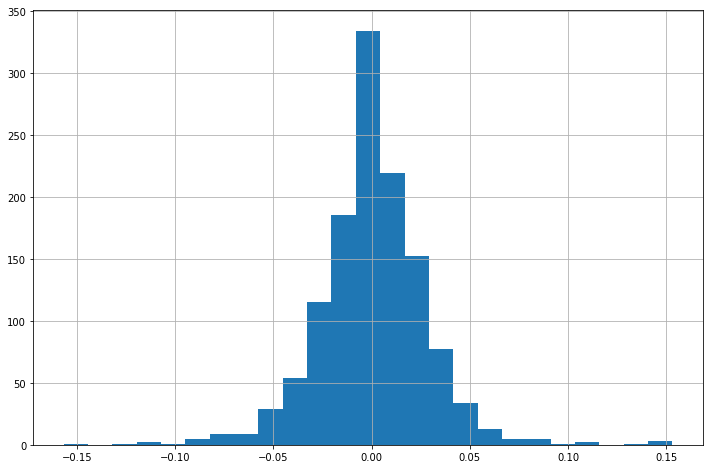

In [4]:
df_tesla['Log_Ret'] = np.log(df_tesla['close'] / df_tesla['close'].shift(1))
df_tesla['Log_Ret'].hist(bins=25, figsize=(12,8))
df_tesla1['Log_Ret'] = np.log(df_tesla['close'] / df_tesla['close'].shift(1))


In [5]:

trace = go.Candlestick(x=df_tesla.index,
                       open=df_tesla.open,
                       high=df_tesla.high,
                       low=df_tesla.low,
                       close=df_tesla.close)

layout = go.Layout(
        xaxis = dict(
        rangeslider = dict(
            visible = False
        )
    )
)

data = [trace]

fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='tesla_candelStick')

In [6]:
#df_tesla['Log_Ret'].describe()

Log feature

In [7]:
df_tesla['Log_Ret'].min()
df_tesla['Log_Ret'].quantile(q=0.25)
df_tesla['Log_Ret'].quantile(q=0.5)
df_tesla['Log_Ret'].quantile(q=0.75)
df_tesla['Log_Ret'].max()

#df_tesla['up'] = 0
#df_tesla['Bup'] = 0


#conditions = [
#    df_tesla['Log_Ret'] < df_tesla['Log_Ret'].quantile(.25)
#]

#choices = [1]
"""
df_tesla['Bdown'] = np.select(conditions, choices, default=0)

conditions = [
    df_tesla['Log_Ret'] < df_tesla['Log_Ret'].quantile(.5)
]

choices = [1]

df_tesla['down'] = np.select(conditions, choices, default=0)

conditions = [
    df_tesla['Log_Ret'] > df_tesla['Log_Ret'].quantile(.75)
]

choices = [1]

df_tesla['up'] = np.select(conditions, choices, default=0)

conditions = [
    df_tesla['Log_Ret'] > df_tesla['Log_Ret'].max()
]

choices = [1]

df_tesla['Bup'] = np.select(conditions, choices, default=0)

"""

"\ndf_tesla['Bdown'] = np.select(conditions, choices, default=0)\n\nconditions = [\n    df_tesla['Log_Ret'] < df_tesla['Log_Ret'].quantile(.5)\n]\n\nchoices = [1]\n\ndf_tesla['down'] = np.select(conditions, choices, default=0)\n\nconditions = [\n    df_tesla['Log_Ret'] > df_tesla['Log_Ret'].quantile(.75)\n]\n\nchoices = [1]\n\ndf_tesla['up'] = np.select(conditions, choices, default=0)\n\nconditions = [\n    df_tesla['Log_Ret'] > df_tesla['Log_Ret'].max()\n]\n\nchoices = [1]\n\ndf_tesla['Bup'] = np.select(conditions, choices, default=0)\n\n"

In [8]:
df_tesla.dropna(inplace=True)


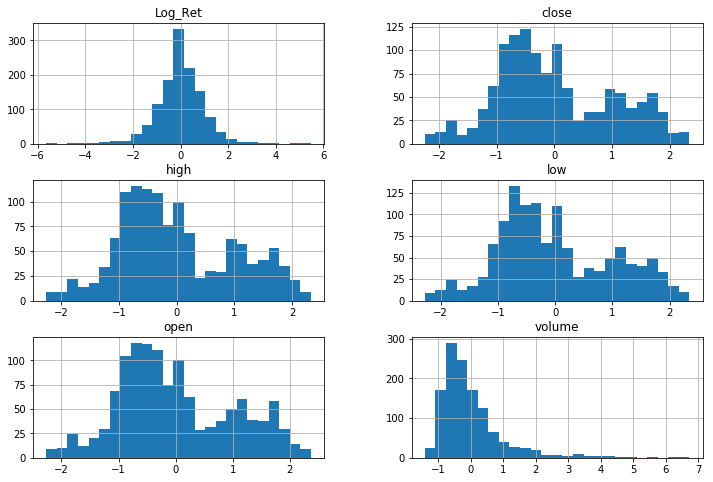

In [9]:
headers = list(df_tesla1.columns.values)
df_copy = pd.DataFrame()
for header in headers:
    df_copy[header] = (df_tesla1[header] - df_tesla1[header].mean()) / (df_tesla1[header].std())
df_copy.hist(bins=25, figsize=(12, 8))
plt.show()

ROC of dataframe

In [10]:
def ROC(df, n):
    M = df['close'].diff(n -1)
    N = df['close'].shift(n -1)
    roc = pd.Series(((M / N) * 100), name = 'roc_' + str(n))   
    return roc

roc_series = ROC(df_tesla, 14)

df_tesla['ROC_14'] = roc_series
df_tesla.dropna(inplace=True)
df_tesla

,open,high,low,close,volume,Log_Ret,ROC_14
date,,,,,,,
2013-10-16,184.9000,187.3000,182.0900,183.560,8205367,-0.002068,-3.844945
2013-10-17,183.5400,184.8000,180.9900,182.802,6704968,-0.004138,-5.465170
2013-10-18,184.1500,185.9600,182.5200,183.400,5930815,0.003266,-4.974093
2013-10-21,183.2800,183.3900,171.0000,172.600,11532131,-0.060693,-4.614534
2013-10-22,170.5000,177.7800,166.1100,171.540,11394675,-0.006160,-1.021291
2013-10-23,168.9100,171.8100,160.1500,164.500,13327739,-0.041906,-9.105979
2013-10-24,165.0000,174.5000,162.8255,173.150,10825667,0.051248,-5.418692
2013-10-25,174.2100,174.5000,166.8000,169.660,7595458,-0.020362,-2.901620
2013-10-28,170.1800,170.5000,162.2000,162.860,7841727,-0.040905,-3.507525


In [11]:
#def ROC(df, tf): 
#    headers = list(df.columns.values)
#    temp = []
#    temp_dict = dict()
#    df_tesla_dropped = df_tesla.iloc[tf:] 

    
#    for idx, header in enumerate(headers):
#        roc = []
#        x = tf
#        tempList = []
#        while x < len(df[header]):
#            #print(df[header] , df[header][x])
#            rocs = (df[header][x] - df[header][x - tf]) / df[header][x - tf] * 100.00
#            roc.append('{:.0f}'.format(rocs))
        
#            x+=1
#        temp_dict['roc_' + header] = roc
#        #print(len(roc))
#        df_tesla_dropped['roc_' + header] = roc
#        #temp_dict['roc_' + header + '_indicator' ] = tempList 
#    return df_tesla_dropped

#df_roc = pd.DataFrame()
#df_roc = df_tesla
#df_roc = ROC(df_tesla[['open', 'high', 'low', 'close']], 14)
#df_roc
#df_roc

#df_tesla
#df_tesla
#df_roc
#frames = [df_tesla, df_roc]
#df_roc.set_index(df_tesla.index, inplace=True)

#result = pd.concat(frames, sort=True)
#result

In [12]:
df_tesla.tail()

,open,high,low,close,volume,Log_Ret,ROC_14
date,,,,,,,
2018-09-18,296.69,302.6400,275.50,284.96,16547522,-0.034084,-6.573555
2018-09-19,280.51,300.0000,280.50,299.02,8294917,0.048162,-1.362362
2018-09-20,303.56,305.9800,293.33,298.33,7349422,-0.002310,-1.103892
2018-09-21,297.70,300.5800,295.37,299.10,5050478,0.002578,3.512718
2018-09-24,298.48,302.9993,293.58,299.68,4842961,0.001937,6.746456


In [13]:
def movingaverage(interval, window_size=10):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [14]:
INCREASING_COLOR = '#00FFFF'
DECREASING_COLOR = '#000000'

In [15]:
data = [ dict(
    type = 'candlestick',
    open = df_tesla.open,
    high = df_tesla.high,
    low = df_tesla.low,
    close = df_tesla.close,
    x = df_tesla.index,
    yaxis = 'y2',
    name = 'GS',
    increasing = dict( line = dict( color = INCREASING_COLOR ) ),
    decreasing = dict( line = dict( color = DECREASING_COLOR ) ),
) ]

layout=dict()

fig = dict( data=data, layout=layout )

In [16]:
fig['layout'] = dict()
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )

In [17]:
rangeselector=dict(
    visibe = True,
    x = 0, y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict( size = 13 ),
    buttons=list([
        dict(count=1,
             label='reset',
             step='all'),
        dict(count=1,
             label='1yr',
             step='year',
             stepmode='backward'),
        dict(count=3,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
    
fig['layout']['xaxis']['rangeselector'] = rangeselector

In [18]:
mv_y = movingaverage(df_tesla.close)
mv_x = list(df_tesla.index)

# Clip the ends
mv_x = mv_x[5:-5]
mv_y = mv_y[5:-5]

fig['data'].append( dict( x=mv_x, y=mv_y, type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = '#E377C2' ),
                         yaxis = 'y2', name='Moving Average' ) )

In [19]:
colors = []

for i in range(len(df_tesla.close)):
    if i != 0:
        if df_tesla.close[i] > df_tesla.close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)

In [20]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.volume,                         
                         marker=dict( color=colors ),
                         type='bar', yaxis='y', name='Volume' ) )

In [21]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.ROC_14, type='scatter', yaxis='y2', 
                         line = dict( width = 1 ),
                         marker=dict(color='#ccc'), 
                         legendgroup='roc_open14', name='roc_open14') )


#fig['data'].append( dict( x=df_tesla.index, y=df_roc.roc_open_indicator, type='scatter', yaxis='y2',
#                         line = dict( width = 1 ),
#                         marker=dict(color='#E377C2'),
#                         legendgroup='roc_30_open_indicator', showlegend=True ) )



In [22]:
py.iplot( fig, filename = 'candlestick_roc_plotting', validate = False )


Regession start

In [23]:
df_tesla['R_AVG'] = df_tesla['close'].rolling(window=5).mean()


Merge df_tesla with df_roc

In [24]:

#df_to_model = df_tesla[['open','high','low','close','volume','Log_Ret']]
#df_to_model['roc_open_30'] = df_roc['roc_open_30']
#df_to_model['roc_close_30'] = df_roc['roc_close_30']
#df_to_model['roc_low_30'] = df_roc['roc_low_30']
#df_to_model['roc_high_30'] = df_roc['roc_high_30']



Calculate the precentail change for eatch column

In [25]:
#df_tesla_pct = df_to_model[['open', 'high', 'low', 'close', 'volume', 'roc_open_30','roc_close_30','roc_low_30','roc_high_30']].pct_change()
#df_tesla_pct = df_to_model.drop(['up','Bup','Bdown','down'], 1)
#df_tesla_pct
#df_to_model.drop(['up','Bup','Bdown', 'down'], 1, inplace=True)

#df_to_model.replace(np.nan, 0, inplace=True)
#df_tesla_pct = df_to_model
#temp_df = df_to_model[['open', 'high', 'low', 'close', 'volume']].pct_change()
#df_tesla_pct = temp_df
#df_tesla_pct
#df_tesla_pct = df_to_model

Remove nans

In [26]:
#df_tesla_pct.replace([np.inf, -np.inf], np.nan, inplace=True)
#df_tesla_pct

Get future value of open price

In [27]:
#df_tesla['open_future'] = df_tesla['open'].shift(-1)
#print(df_tesla_pct[['open_future', 'open']].head())
#df_tesla.head()

Create labels 0 or 1

In [28]:
#df_tesla['label'] = list(map(create_labels, df_tesla_pct['open'], df_tesla_pct['open_future']))
#df_tesla_pct
df = df_tesla.copy()

df_tesla['label'] = df_tesla['open'].shift(-1)
df_tesla.dropna(inplace=True)
#df_tesla.drop(['open_future'], 1 , inplace=True)
df.dropna(inplace=True)
#df_tesla.index

In [29]:
# Get column names first
names = df_tesla.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df_tesla)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.tail(9)

,open,high,low,close,volume,Log_Ret,ROC_14,R_AVG,label
1230,0.495481,0.463035,0.474666,0.495811,0.759444,-0.788032,-1.410766,0.476066,0.528219
1231,0.529742,0.643852,0.564512,0.689115,0.977349,1.385825,-1.022509,0.510376,0.642716
1232,0.644180,0.686904,0.679700,0.670307,0.030124,-0.149986,-1.132354,0.540169,0.655592
1233,0.657050,0.726953,0.703323,0.770268,0.139736,0.690655,-0.853089,0.652061,0.677865
1234,0.679311,0.787990,0.731707,0.763998,0.171171,-0.059881,-0.645104,0.684761,0.793580
1235,0.794967,0.818471,0.509044,0.591941,2.660943,-1.242522,-0.756613,0.704086,0.512036
1236,0.513568,0.773008,0.597193,0.836792,0.533902,1.717185,-0.235906,0.733775,0.913124
1237,0.914448,0.875988,0.823382,0.824776,0.290208,-0.099104,-0.210080,0.764828,0.811155
1238,0.812532,0.782996,0.859346,0.838185,-0.302326,0.076793,0.251216,0.778482,0.824728


Create data to be passed to Neural network

In [30]:

forecast_col = 'close'
# how many days to forecast
forecast_out = int(10)
print('length =',len(df), "and forecast_out =", forecast_out)

length = 1240 and forecast_out = 10


In [31]:
df['label'] = df[forecast_col].shift(-forecast_out)

print(df.head(2))
print('\n')
# If we look at the tail, it consists of n(=forecast_out) rows with NAN in Label column 
print(df.tail(2))
# Learning data, we need to drop label and open_future to not give the answers
#X = np.array(scaled_df.drop(['label'], 1))
#X = np.array(df_tesla_pct.drop(['label'], 1))
# remove when using the other one
#X = preprocessing.scale(X)

              open    high     low   close    volume   Log_Ret    ROC_14  \
date                                                                       
2013-10-22  170.50  177.78  166.11  171.54  11394675 -0.006160 -1.021291   
2013-10-23  168.91  171.81  160.15  164.50  13327739 -0.041906 -9.105979   

               R_AVG   label  
date                          
2013-10-22  178.7804  176.81  
2013-10-23  174.9684  151.16  


              open      high     low   close   volume   Log_Ret    ROC_14  \
date                                                                        
2018-09-21  297.70  300.5800  295.37  299.10  5050478  0.002578  3.512718   
2018-09-24  298.48  302.9993  293.58  299.68  4842961  0.001937  6.746456   

              R_AVG  label  
date                        
2018-09-21  295.250    NaN  
2018-09-24  296.218    NaN  


In [32]:
# Label data only include the labels
#Y = np.array(scaled_df['label'])

In [33]:
# Define features Matrix X by excluding the label column which we just created 
X = np.array(df.drop(['label'], 1))

# Using a feature in sklearn, preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-1.42820113 -1.43536856 -1.52540389 -1.50669275  1.83200271 -1.52465843
 -1.01039185 -1.32788411]


In [34]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))


Length of X_forecast_out: 10 & Length of X : 1230


In [35]:
# Similarly Define Label vector y for the data we have prediction for
# A good test is to make sure length of X and y are identical
y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))


Length of y:  1230


In [36]:
# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  984 246


In [37]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.8884163292587334


In [38]:


forecast_prediction = clf.predict(X_forecast_out)


In [39]:
df
df.dropna(inplace=True)

forecast_prediction = np.insert(forecast_prediction, 0, df.iloc[-1].close)


In [40]:
# Plotting data
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

[285.5        275.52157599 286.48048165 285.19507401 291.34441407
 291.58805776 281.20493019 296.0553125  293.70801153 296.1601484
 295.97278067]


In [41]:
p1 = go.Scatter(x=df.index,
                y=df.close, 
                mode='lines',
                name='predicted',
                marker=dict(color='green')
               )
p2 = go.Scatter(x=df.index, 
                y=df.forecast,
                mode='lines',
                name='forecast',
                line=dict(color='blue', width=3)
                )

layout = go.Layout(title='Forecast plot',
xaxis=dict(title='Date',ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(title='Price',ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[p1, p2], layout=layout)

py.iplot(fig)

Preprocess the data

In [42]:
#Y = Y.reshape(-1,1)

#scaler = preprocessing.StandardScaler().fit(Y)

#X = scaler.transform(X)
#y = scaler.transform(Y)



In [43]:
tscv = TimeSeriesSplit(n_splits=5)

Split the training and test data

In [44]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

NameError: name 'Y' is not defined

Train the model

In [ ]:
linear = ElasticNetCV()

In [ ]:
linear.fit(X_train, Y_train.reshape(len(Y_train)))

In [ ]:
linear.score(X_test, Y_test)

In [ ]:
X_test[:5]

In [ ]:
forecat_set = linear.predict(X_test)

In [ ]:
forecat_set[:5]

In [ ]:
Y_test[:5]

Testing with svm

In [ ]:
#X_train2, X_test2, Y_train2, Y_test2 = cross_validation.train_test_split(X, Y, test_size=0.2)

In [ ]:
#clf = svm.SVC(kernel='linear')
#clf.fit(X_train2, Y_train2)
#print(clf.score(X_test2, Y_test2))


Tesing with linearRegression

In [ ]:
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_test) - Y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, Y_test))

In [ ]:
def data_to_plotly(x):
    k = []
    
    for i in range(0, len(x)):
        k.append(x[i][0])
        
    return k

In [ ]:

convolved = np.convolve(Y_test, forecat_set)



In [ ]:
p1 = go.Scatter(x=X_test,
                y=Y_test.flatten(), 
                mode='markers',
                name='predicted',
                marker=dict(color='green')
               )
p2 = go.Scatter(x=df_tesla.index, 
                y=convolved,
                mode='lines',
                name='forecast',
                line=dict(color='blue', width=3)
                )

layout = go.Layout(xaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[p1, p2], layout=layout)

py.iplot(fig)

In [ ]:
trace1 = go.Scatter(dict(line=dict(color='darkblue'),
                      x=df_tesla.index,
                      y=Y_test.flatten(),
                      name='predicted'))

trace2 = go.Scatter(dict(line=dict(color='green'),
                      x=df_tesla.index,
                      y=forecat_set,
                      name='forecast'))



layout = go.Layout(xaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[trace1, trace2], layout=layout)

py.iplot(fig)

In [ ]:
x = np.arange(df_tesla.index.size) # = array([0, 1, 2, ..., 3598, 3599, 3600])
fit = np.polyfit(x, X_test, 1)
fit_fn = np.poly1d(fit)
plt.plot(df_tesla.index, fit_fn(x), 'k-')
plt.plot(df_tesla.index, X_test, 'go', ms=2)

In [ ]:
model = LinearRegression(fit_intercept=True)

model.fit(X[:, np.newaxis], Y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])